[Expt/trainable-forgetting-decay](https://github.com/open-spaced-repetition/fsrs-optimizer/tree/Expt/trainable-forgetting-decay)

In [1]:
import numpy as np
import pandas as pd
import os
import sys

sys.path.insert(0, os.path.abspath("../fsrs-optimizer/src/fsrs_optimizer/"))

from fsrs_optimizer import simulate, Optimizer

initial_parameters = [
    1.1596,
    1.7974,
    13.1205,
    49.3729,
    7.2303,
    0.5081,
    1.5371,
    0.0010,
    1.5052,
    0.1261,
    0.9735,
    1.8924,
    0.1486,
    0.2407,
    2.1937,
    0.1518,
    3.0699,
    0,
    0,
    1,
]


def generate_revlog_from_simulation(initial_parameters, learn_span):
    flattened_revlogs = []
    for i, r in enumerate([0.8]):
        _, _, _, _, _, revlogs = simulate(
            w=initial_parameters,
            request_retention=r,
            deck_size=30000,
            learn_span=learn_span,
            max_cost_perday=3600,
            first_rating_offset=np.array([0, 0, 0, 0]),
            first_session_len=np.array([0, 0, 0, 0]),
            forget_rating_offset=0,
            forget_session_len=0,
            fuzz=True,
        )

        for day in revlogs:
            card_ids = revlogs[day]["card_id"]
            ratings = revlogs[day]["rating"]
            for card_id, rating in zip(card_ids, ratings):
                flattened_revlogs.append(
                    {
                        "card_id": card_id + i * 30000,
                        "review_rating": int(rating),
                        "day": day,
                    }
                )
    return flattened_revlogs

In [2]:
from itertools import accumulate


def preprocess_revlog(flattened_revlogs):
    df = pd.DataFrame(flattened_revlogs)
    df["review_time"] = range(1, df.shape[0] + 1)
    df.sort_values(by=["card_id", "day"], inplace=True, ignore_index=True)
    df["delta_t"] = df.groupby("card_id")["day"].diff().fillna(0).astype(int)
    df["i"] = df.groupby("card_id").cumcount() + 1
    df.loc[df["i"] == 1, "delta_t"] = -1

    def cum_concat(x):
        return list(accumulate(x))

    t_history_list = df.groupby("card_id", group_keys=False)["delta_t"].apply(
        lambda x: cum_concat([[max(0, int(i))] for i in x])
    )
    df["t_history"] = [
        ",".join(map(str, item[:-1])) for sublist in t_history_list for item in sublist
    ]
    r_history_list = df.groupby("card_id", group_keys=False)["review_rating"].apply(
        lambda x: cum_concat([[i] for i in x])
    )
    df["r_history"] = [
        ",".join(map(str, item[:-1])) for sublist in r_history_list for item in sublist
    ]
    last_rating = []
    for t_sublist, r_sublist in zip(t_history_list, r_history_list):
        for t_history, r_history in zip(t_sublist, r_sublist):
            flag = True
            for t, r in zip(reversed(t_history[:-1]), reversed(r_history[:-1])):
                if t > 0:
                    last_rating.append(r)
                    flag = False
                    break
            if flag:
                last_rating.append(r_history[0])
    df["last_rating"] = last_rating
    df = df[
        (df["review_rating"] != 0)
        & (df["r_history"].str.contains("0") == 0)
        & (df["delta_t"] != 0)
    ].copy()

    df["i"] = df.groupby("card_id").cumcount() + 1
    df["first_rating"] = df["r_history"].map(lambda x: x[0] if len(x) > 0 else "")
    df["y"] = df["review_rating"].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
    df = df[(df["i"] > 1) & (df["delta_t"] > 0)].copy()
    return df

In [3]:
import matplotlib.pyplot as plt

decay_list = []
trained_parameters = None


def train_and_evaluate(df):
    plt.close("all")
    sample_size = len(df)
    print(f"sample size: {sample_size}")
    optimizer = Optimizer(enable_short_term=False)
    optimizer.S0_dataset_group = (
        df[df["i"] == 2]
        .groupby(by=["first_rating", "delta_t"], group_keys=False)
        .agg({"y": ["mean", "count"]})
        .reset_index()
    )
    optimizer.define_model()
    optimizer.pretrain(dataset=df, verbose=False)
    optimizer.train(gamma=0, verbose=False)
    global trained_parameters
    trained_parameters = optimizer.w
    decay_list.append(optimizer.w[19])
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    deviations = []
    for param, trained_param in zip(initial_parameters, trained_parameters):
        if param == 0 and trained_param == 0:
            continue
        smape = abs(param - trained_param) / ((abs(param) + abs(trained_param)) / 2)
        deviations.append(smape)
        print(f"{param} -> {trained_param}: SMAPE={smape:.4%}")
    avg_smape = np.mean(deviations)
    print(f"Avg. SMAPE: {avg_smape:.4%}")
    return sample_size, loss_after, rmse, auc, avg_smape, optimizer.dataset


def evaluate_initial_parameters(dataset):
    optimizer = Optimizer()
    optimizer.dataset = dataset
    optimizer.w = initial_parameters
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    return loss_after, rmse, auc

learn_span: 30


sample size: 2503


  0%|          | 0/2503 [00:00<?, ?it/s]

loss before: 0.5179, loss after: 0.4897
RMSE(bins): 0.0332
AUC: 0.5986
1.1596 -> 1.1014: SMAPE=5.1482%
1.7974 -> 2.0918: SMAPE=15.1394%
13.1205 -> 13.1476: SMAPE=0.2063%
49.3729 -> 63.5159: SMAPE=25.0565%
7.2303 -> 7.1926: SMAPE=0.5228%
0.5081 -> 0.5062: SMAPE=0.3746%
1.5371 -> 1.4283: SMAPE=7.3380%
0.001 -> 0.118: SMAPE=196.6387%
1.5052 -> 1.557: SMAPE=3.3832%
0.1261 -> 0.0067: SMAPE=179.8193%
0.9735 -> 1.0352: SMAPE=6.1433%
1.8924 -> 1.872: SMAPE=1.0838%
0.1486 -> 0.1908: SMAPE=24.8674%
0.2407 -> 0.2605: SMAPE=7.9010%
2.1937 -> 2.1959: SMAPE=0.1002%
0.1518 -> 0.158: SMAPE=4.0026%
3.0699 -> 3.1931: SMAPE=3.9342%
1 -> 0.4628: SMAPE=73.4482%
Avg. SMAPE: 30.8393%
loss before: 0.5179, loss after: 0.4911
RMSE(bins): 0.0376
AUC: 0.5902
--------------------------------
learn_span: 60


sample size: 7190


  0%|          | 0/7190 [00:00<?, ?it/s]

loss before: 0.5432, loss after: 0.5035
RMSE(bins): 0.0262
AUC: 0.5696
1.1596 -> 0.9824: SMAPE=16.5453%
1.7974 -> 2.1169: SMAPE=16.3248%
13.1205 -> 11.573: SMAPE=12.5337%
49.3729 -> 47.8802: SMAPE=3.0697%
7.2303 -> 7.2168: SMAPE=0.1869%
0.5081 -> 0.2487: SMAPE=68.5518%
1.5371 -> 1.3798: SMAPE=10.7854%
0.001 -> 0.0324: SMAPE=188.0240%
1.5052 -> 1.4708: SMAPE=2.3118%
0.1261 -> 0.2953: SMAPE=80.3037%
0.9735 -> 0.9786: SMAPE=0.5225%
1.8924 -> 1.8252: SMAPE=3.6152%
0.1486 -> 0.2219: SMAPE=39.5682%
0.2407 -> 0.2693: SMAPE=11.2157%
2.1937 -> 2.2319: SMAPE=1.7263%
0.1518 -> 0.2731: SMAPE=57.0958%
3.0699 -> 3.1862: SMAPE=3.7180%
1 -> 0.4394: SMAPE=77.8936%
Avg. SMAPE: 32.9996%
loss before: 0.5432, loss after: 0.5039
RMSE(bins): 0.0277
AUC: 0.5651
--------------------------------
learn_span: 120


sample size: 16309


  0%|          | 0/16309 [00:00<?, ?it/s]

loss before: 0.5378, loss after: 0.5051
RMSE(bins): 0.0202
AUC: 0.5614
1.1596 -> 0.9799: SMAPE=16.7983%
1.7974 -> 1.807: SMAPE=0.5327%
13.1205 -> 10.8932: SMAPE=18.5502%
49.3729 -> 46.6511: SMAPE=5.6690%
7.2303 -> 7.1889: SMAPE=0.5742%
0.5081 -> 0.2786: SMAPE=58.3450%
1.5371 -> 1.6382: SMAPE=6.3679%
0.001 -> 0.0066: SMAPE=147.3684%
1.5052 -> 1.4625: SMAPE=2.8776%
0.1261 -> 0.1762: SMAPE=33.1459%
0.9735 -> 0.9895: SMAPE=1.6302%
1.8924 -> 1.8321: SMAPE=3.2380%
0.1486 -> 0.2278: SMAPE=42.0829%
0.2407 -> 0.2789: SMAPE=14.7036%
2.1937 -> 2.2526: SMAPE=2.6494%
0.1518 -> 0.2605: SMAPE=52.7286%
3.0699 -> 2.8807: SMAPE=6.3590%
1 -> 0.4601: SMAPE=73.9538%
Avg. SMAPE: 27.0875%
loss before: 0.5378, loss after: 0.5055
RMSE(bins): 0.0223
AUC: 0.5584
--------------------------------
learn_span: 240


sample size: 36390


  0%|          | 0/36390 [00:00<?, ?it/s]

loss before: 0.5317, loss after: 0.5018
RMSE(bins): 0.0170
AUC: 0.5568
1.1596 -> 1.0271: SMAPE=12.1187%
1.7974 -> 1.8515: SMAPE=2.9653%
13.1205 -> 11.2377: SMAPE=15.4593%
49.3729 -> 54.299: SMAPE=9.5033%
7.2303 -> 7.2421: SMAPE=0.1631%
0.5081 -> 0.3471: SMAPE=37.6520%
1.5371 -> 1.6578: SMAPE=7.5558%
0.001 -> 0.0089: SMAPE=159.5960%
1.5052 -> 1.4231: SMAPE=5.6073%
0.1261 -> 0.1113: SMAPE=12.4684%
0.9735 -> 1.0272: SMAPE=5.3681%
1.8924 -> 1.7788: SMAPE=6.1887%
0.1486 -> 0.2201: SMAPE=38.7849%
0.2407 -> 0.2621: SMAPE=8.5123%
2.1937 -> 2.4143: SMAPE=9.5747%
0.1518 -> 0.2086: SMAPE=31.5205%
3.0699 -> 3.2869: SMAPE=6.8273%
1 -> 0.4033: SMAPE=85.0424%
Avg. SMAPE: 25.2727%
loss before: 0.5317, loss after: 0.5019
RMSE(bins): 0.0169
AUC: 0.5563
--------------------------------
learn_span: 480


sample size: 77975


  0%|          | 0/77975 [00:00<?, ?it/s]

loss before: 0.5271, loss after: 0.5021
RMSE(bins): 0.0132
AUC: 0.5539
1.1596 -> 1.0001: SMAPE=14.7706%
1.7974 -> 1.8881: SMAPE=4.9220%
13.1205 -> 11.3599: SMAPE=14.3838%
49.3729 -> 51.5242: SMAPE=4.2643%
7.2303 -> 6.9858: SMAPE=3.4398%
0.5081 -> 0.3388: SMAPE=39.9811%
1.5371 -> 1.5367: SMAPE=0.0260%
0.001 -> 0.004: SMAPE=120.0000%
1.5052 -> 1.3691: SMAPE=9.4701%
0.1261 -> 0.1089: SMAPE=14.6383%
0.9735 -> 1.0663: SMAPE=9.0989%
1.8924 -> 1.7491: SMAPE=7.8704%
0.1486 -> 0.2219: SMAPE=39.5682%
0.2407 -> 0.259: SMAPE=7.3244%
2.1937 -> 2.6432: SMAPE=18.5863%
0.1518 -> 0.1689: SMAPE=10.6642%
3.0699 -> 3.0024: SMAPE=2.2232%
1 -> 0.4245: SMAPE=80.8003%
Avg. SMAPE: 22.3351%
loss before: 0.5271, loss after: 0.5020
RMSE(bins): 0.0132
AUC: 0.5544
--------------------------------
learn_span: 960


sample size: 164808


  0%|          | 0/164808 [00:00<?, ?it/s]

loss before: 0.5210, loss after: 0.5005
RMSE(bins): 0.0126
AUC: 0.5497
1.1596 -> 1.0022: SMAPE=14.5619%
1.7974 -> 1.7546: SMAPE=2.4099%
13.1205 -> 11.0214: SMAPE=17.3897%
49.3729 -> 47.7707: SMAPE=3.2986%
7.2303 -> 6.7915: SMAPE=6.2588%
0.5081 -> 0.4689: SMAPE=8.0246%
1.5371 -> 1.653: SMAPE=7.2662%
0.001 -> 0.0031: SMAPE=102.4390%
1.5052 -> 1.2406: SMAPE=19.2731%
0.1261 -> 0.1304: SMAPE=3.3528%
0.9735 -> 1.1819: SMAPE=19.3375%
1.8924 -> 1.4603: SMAPE=25.7762%
0.1486 -> 0.217: SMAPE=37.4179%
0.2407 -> 0.287: SMAPE=17.5478%
2.1937 -> 2.8037: SMAPE=24.4127%
0.1518 -> 0.1749: SMAPE=14.1414%
3.0699 -> 2.9111: SMAPE=5.3101%
1 -> 0.3649: SMAPE=93.0618%
Avg. SMAPE: 23.4045%
loss before: 0.5210, loss after: 0.5005
RMSE(bins): 0.0122
AUC: 0.5506
--------------------------------
learn_span: 1920


sample size: 306337


  0%|          | 0/306337 [00:00<?, ?it/s]

loss before: 0.5164, loss after: 0.4996
RMSE(bins): 0.0095
AUC: 0.5467
1.1596 -> 1.0015: SMAPE=14.6314%
1.7974 -> 1.7023: SMAPE=5.4348%
13.1205 -> 11.4501: SMAPE=13.5967%
49.3729 -> 48.6181: SMAPE=1.5405%
7.2303 -> 6.5574: SMAPE=9.7609%
0.5081 -> 0.4841: SMAPE=4.8377%
1.5371 -> 1.5369: SMAPE=0.0130%
0.001 -> 0.0035: SMAPE=111.1111%
1.5052 -> 1.0837: SMAPE=32.5621%
0.1261 -> 0.1391: SMAPE=9.8039%
0.9735 -> 1.3161: SMAPE=29.9266%
1.8924 -> 1.4259: SMAPE=28.1168%
0.1486 -> 0.1846: SMAPE=21.6086%
0.2407 -> 0.2686: SMAPE=10.9562%
2.1937 -> 2.9868: SMAPE=30.6187%
0.1518 -> 0.1583: SMAPE=4.1922%
3.0699 -> 2.9676: SMAPE=3.3888%
1 -> 0.3922: SMAPE=87.3150%
Avg. SMAPE: 23.3008%
loss before: 0.5164, loss after: 0.4995
RMSE(bins): 0.0090
AUC: 0.5476
--------------------------------


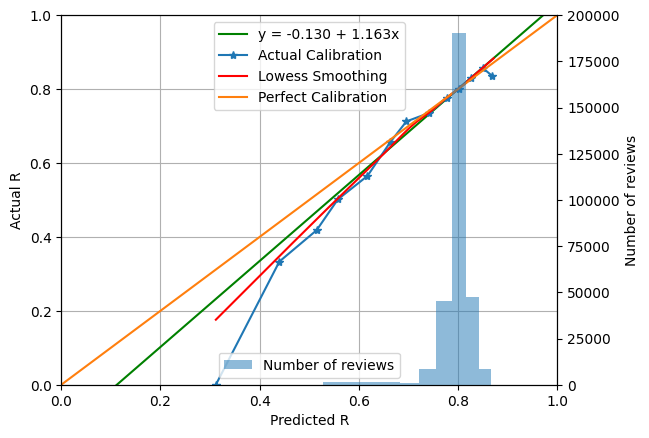

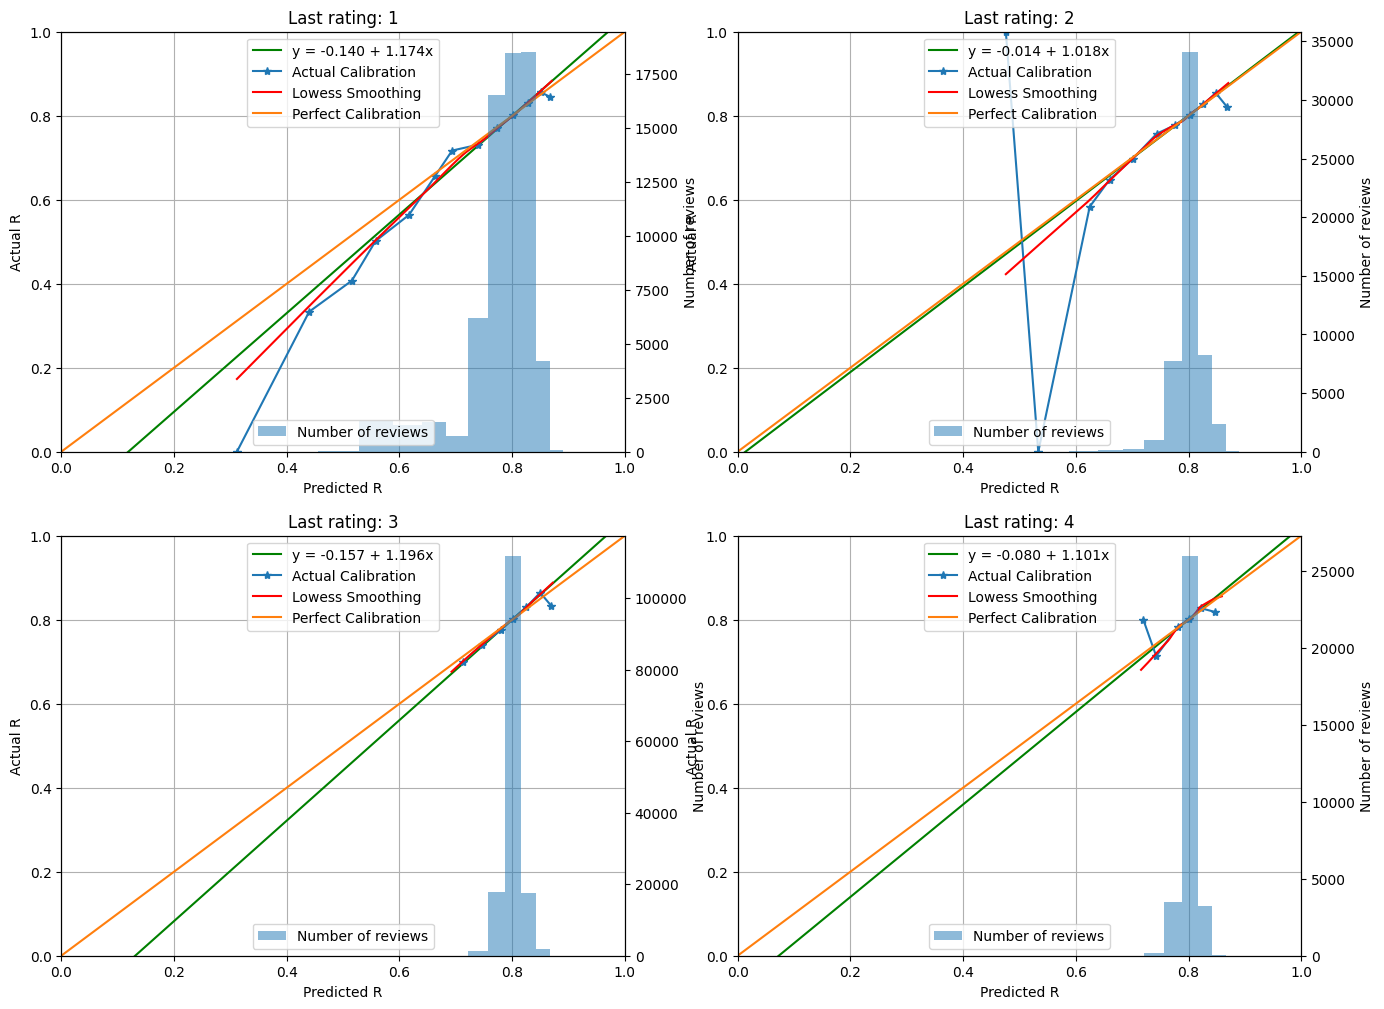

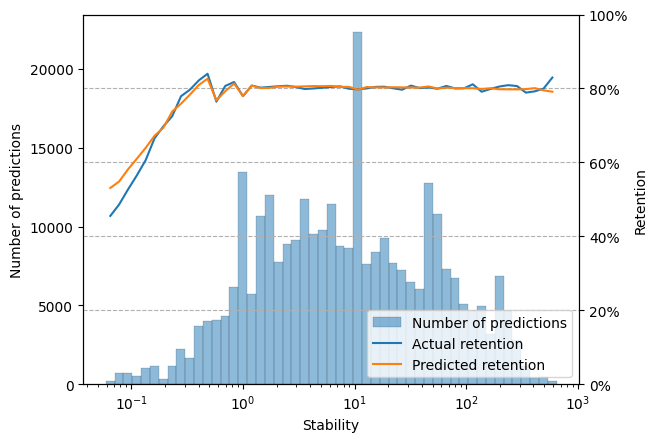

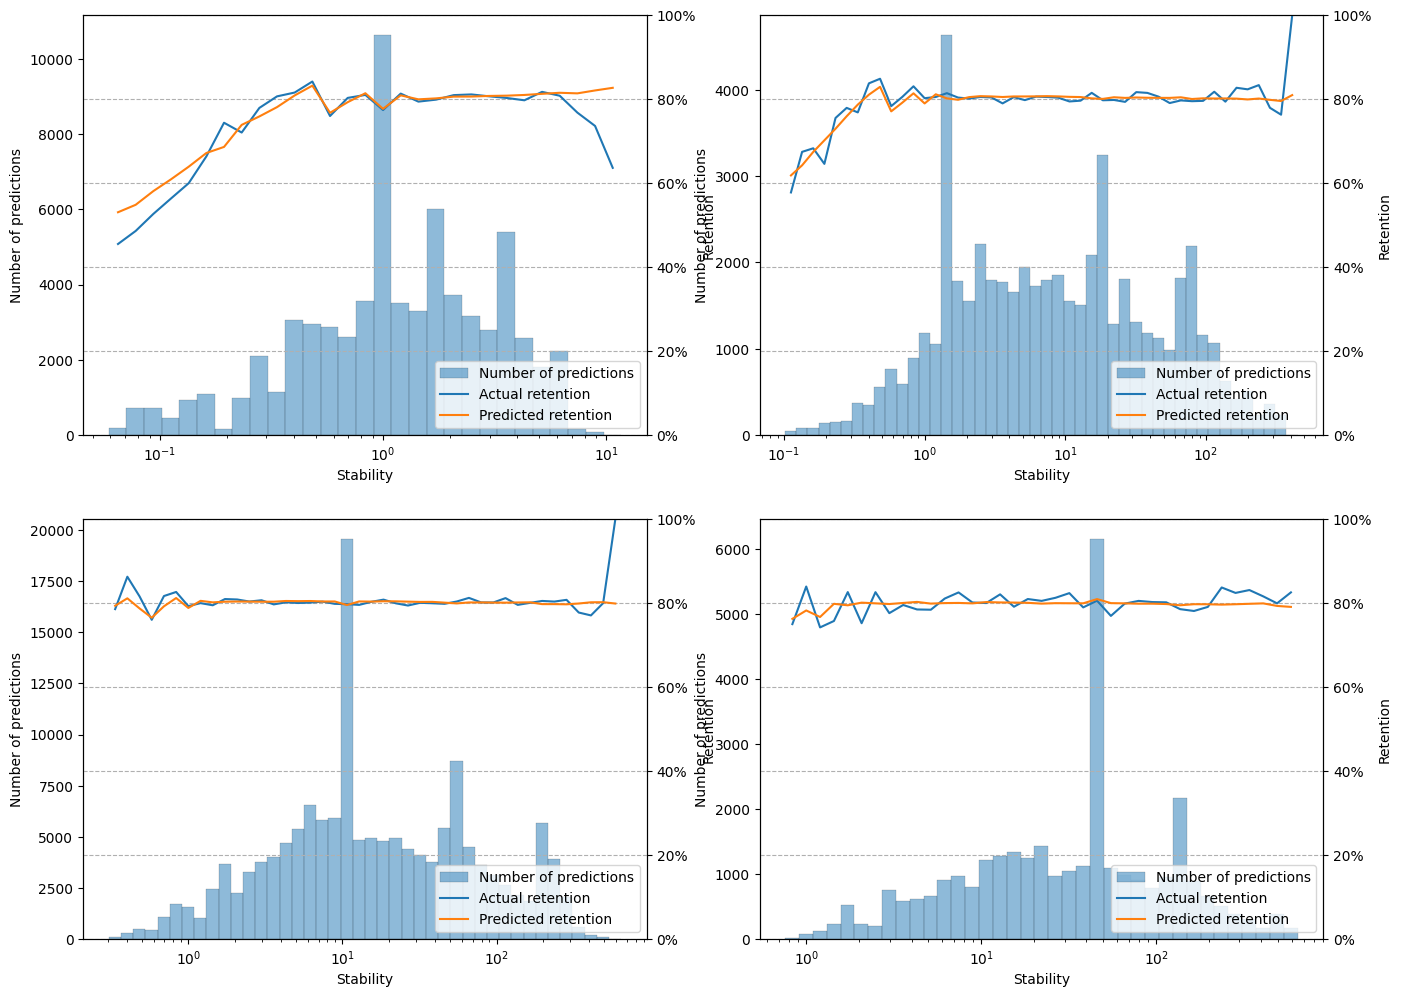

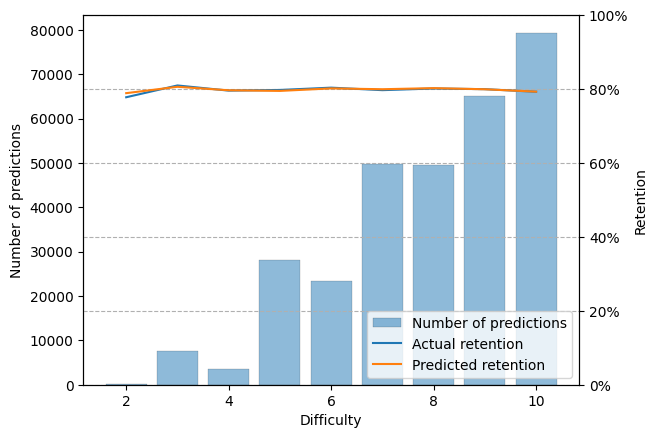

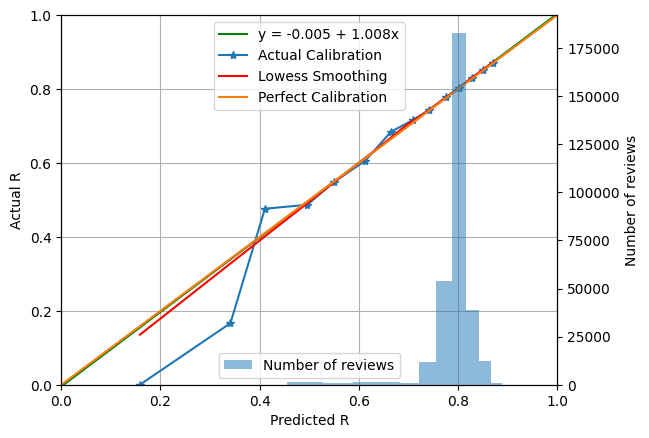

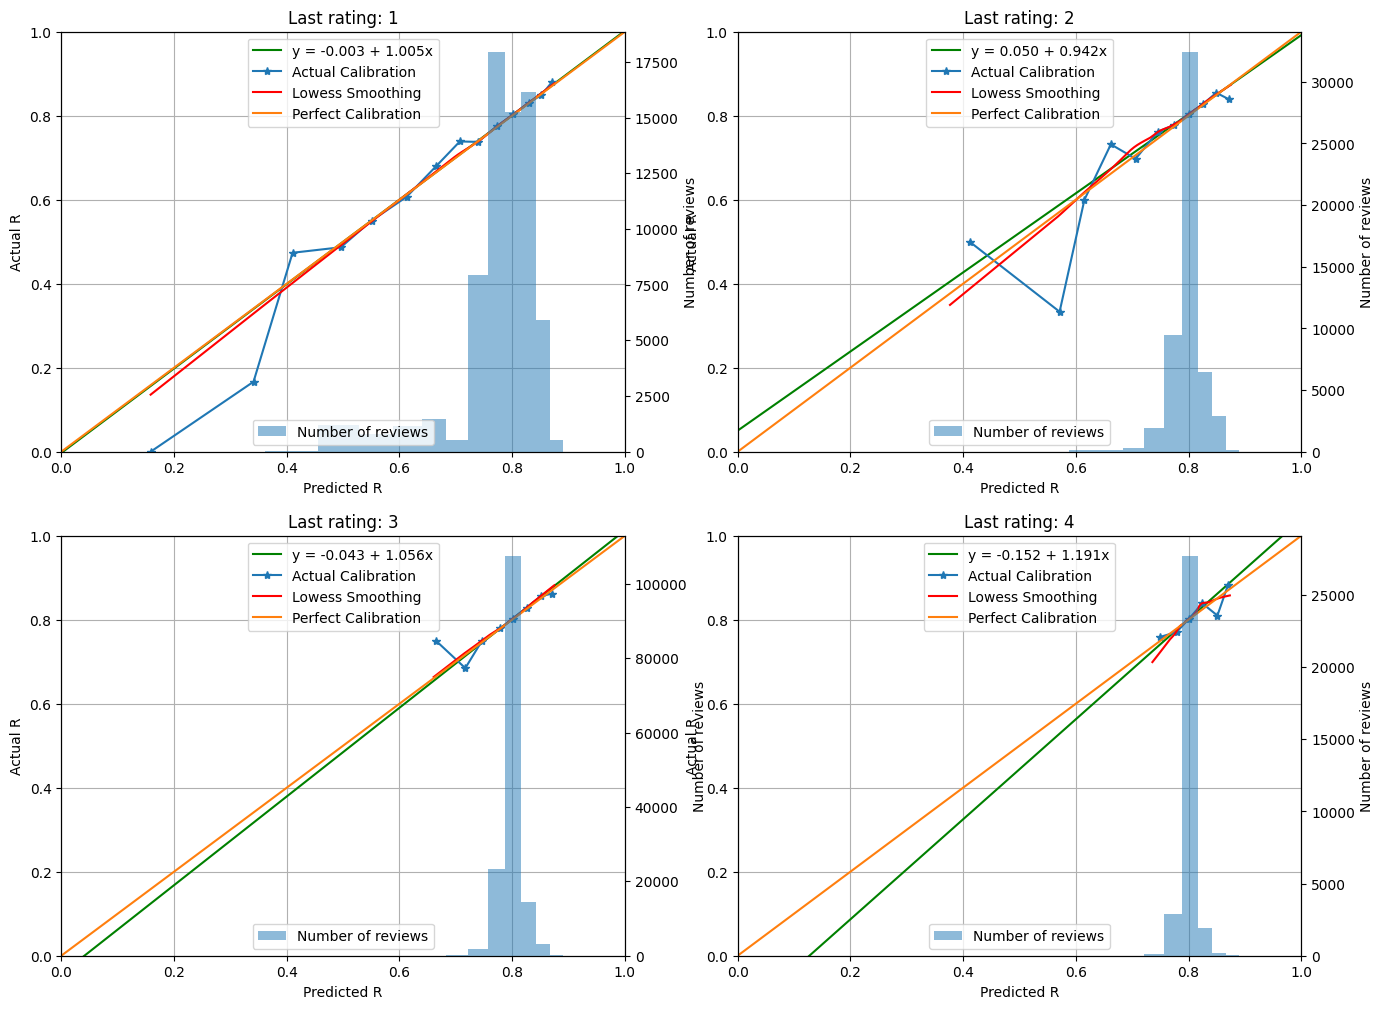

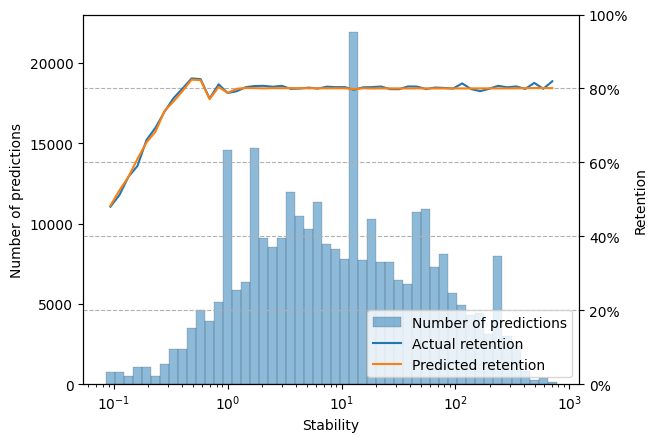

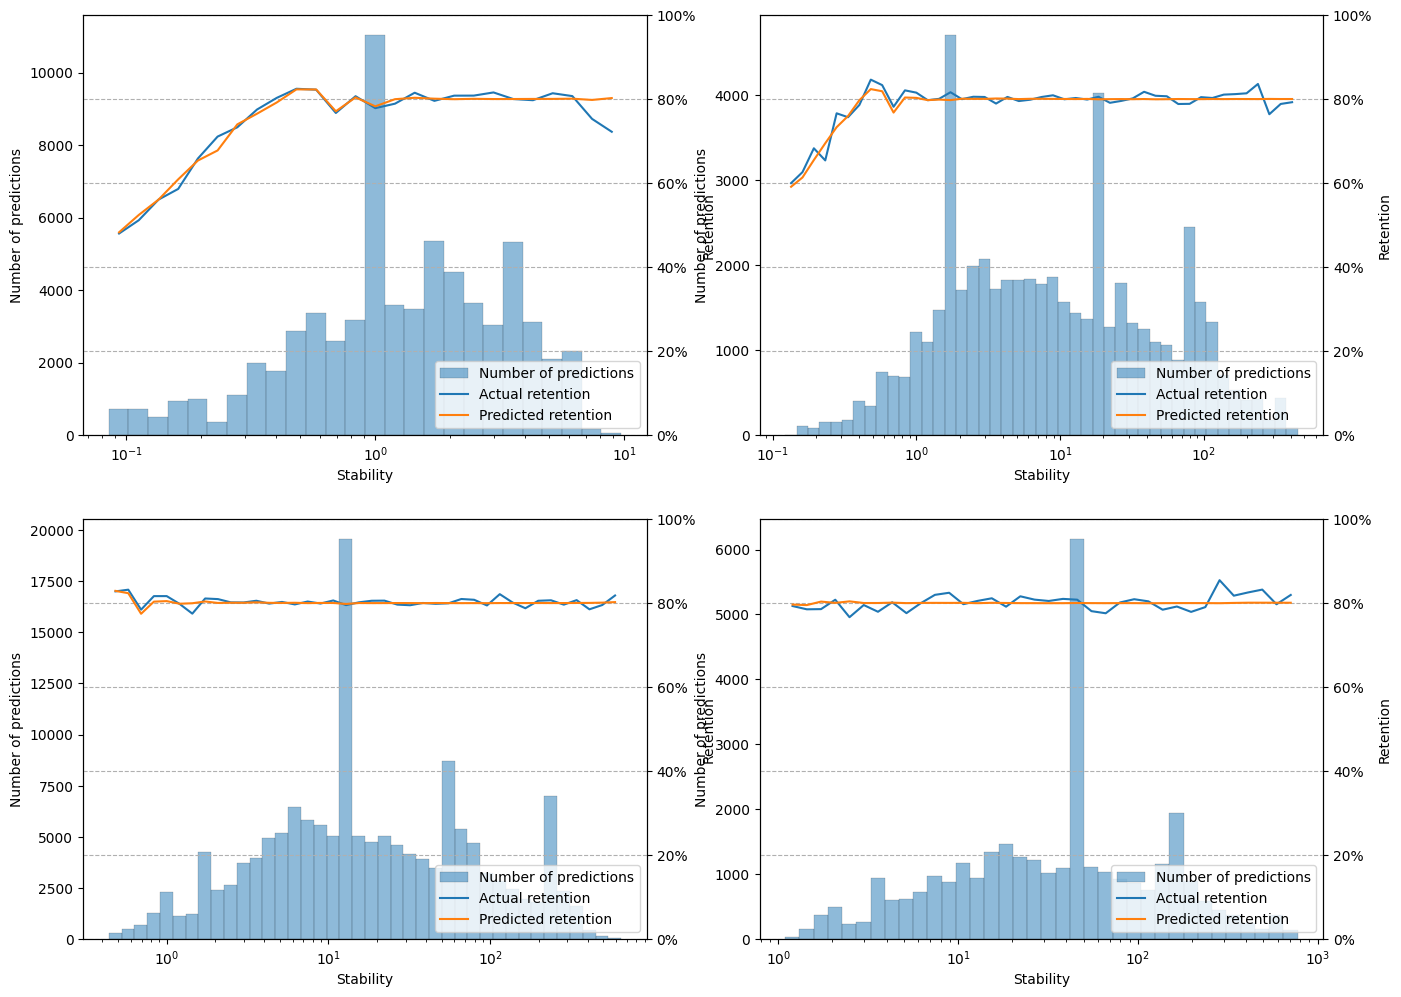

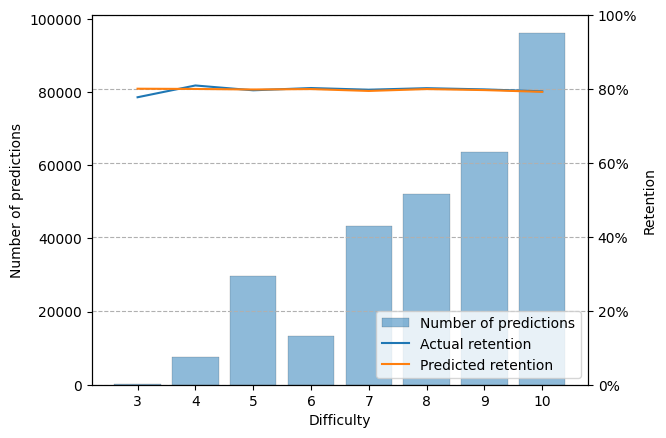

In [4]:
learn_span_list = [30, 60, 120, 240, 480, 960, 1920]
sample_size_list = []
logloss_list = []
rmse_list = []
auc_list = []
avg_smape_list = []
ideal_logloss_list = []
ideal_rmse_list = []
ideal_auc_list = []

for learn_span in learn_span_list:
    print(f"learn_span: {learn_span}")
    revlogs = generate_revlog_from_simulation(initial_parameters, learn_span=learn_span)
    df = preprocess_revlog(revlogs)
    sample_size, logloss, rmse, auc, avg_smape, dataset = train_and_evaluate(df)
    sample_size_list.append(sample_size)
    logloss_list.append(logloss)
    rmse_list.append(rmse)
    auc_list.append(auc)
    avg_smape_list.append(avg_smape)

    ideal_logloss, ideal_rmse, ideal_auc = evaluate_initial_parameters(dataset)
    ideal_logloss_list.append(ideal_logloss)
    ideal_rmse_list.append(ideal_rmse)
    ideal_auc_list.append(ideal_auc)

    print("--------------------------------")

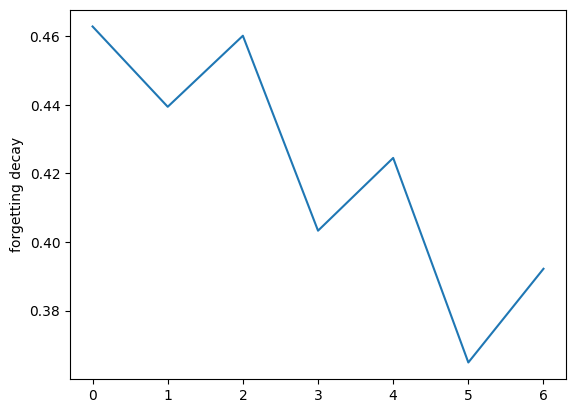

In [5]:
plt.plot(decay_list)
plt.ylabel("forgetting decay")
plt.show()

In [6]:
np.set_printoptions(precision=6, suppress=True)
print(
    f"logloss (trained - ideal): {np.array(logloss_list) - np.array(ideal_logloss_list)}"
)
print(
    f"RMSE(bins) (trained - ideal): {np.array(rmse_list) - np.array(ideal_rmse_list)}"
)
print(f"AUC (trained - ideal): {np.array(auc_list) - np.array(ideal_auc_list)}")

logloss (trained - ideal): [-0.001401 -0.000438 -0.000377 -0.000031  0.000033  0.000075  0.000113]
RMSE(bins) (trained - ideal): [-0.004361 -0.001489 -0.002109  0.000114  0.000081  0.000395  0.000457]
AUC (trained - ideal): [ 0.008422  0.004513  0.002995  0.000582 -0.000561 -0.000898 -0.00093 ]


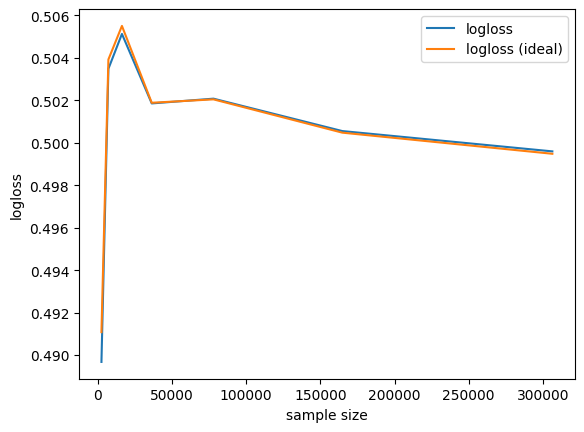

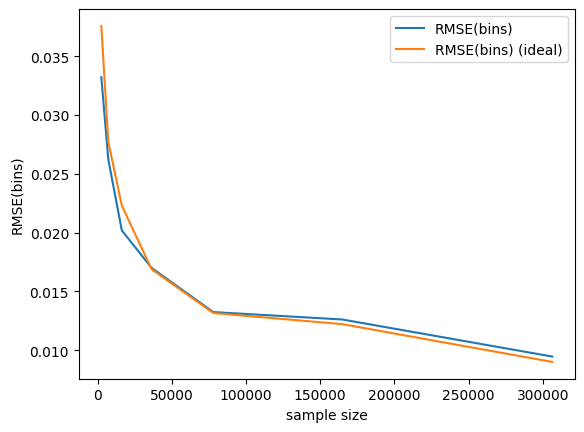

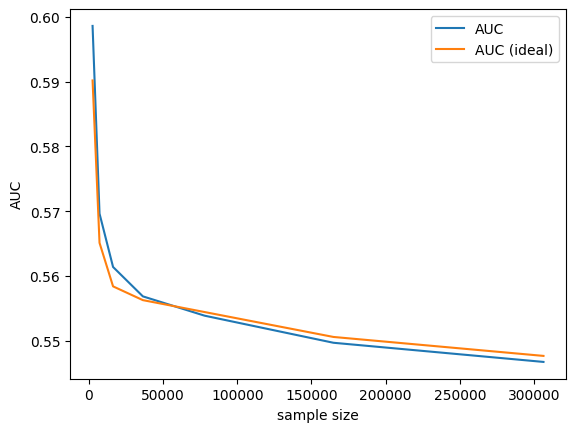

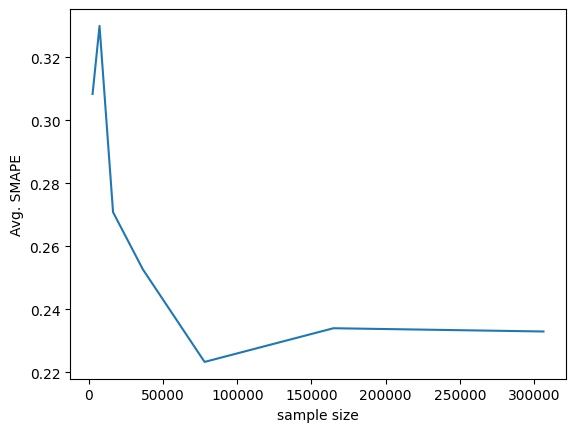

In [7]:
plt.plot(sample_size_list, logloss_list, label="logloss")
plt.plot(sample_size_list, ideal_logloss_list, label="logloss (ideal)")
plt.ylabel("logloss")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, rmse_list, label="RMSE(bins)")
plt.plot(sample_size_list, ideal_rmse_list, label="RMSE(bins) (ideal)")
plt.ylabel("RMSE(bins)")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, auc_list, label="AUC")
plt.plot(sample_size_list, ideal_auc_list, label="AUC (ideal)")
plt.ylabel("AUC")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, avg_smape_list)
plt.ylabel("Avg. SMAPE")
plt.xlabel("sample size")
plt.show()

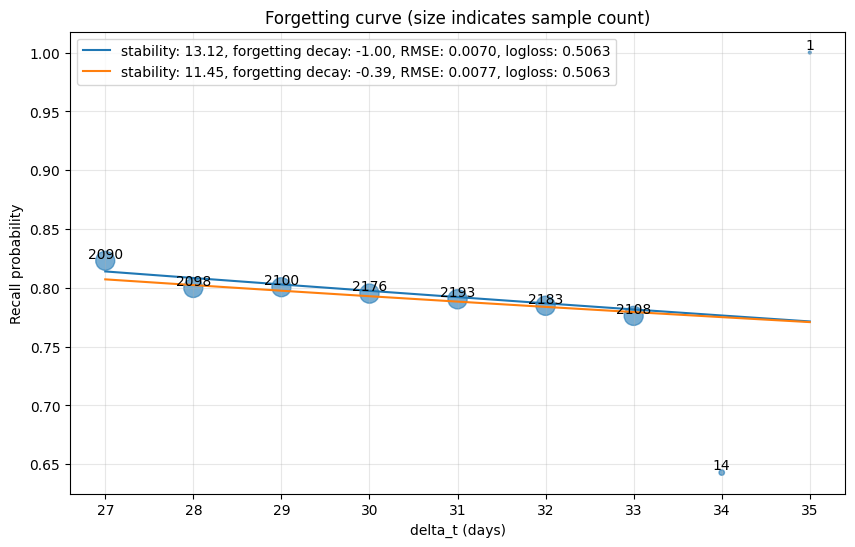

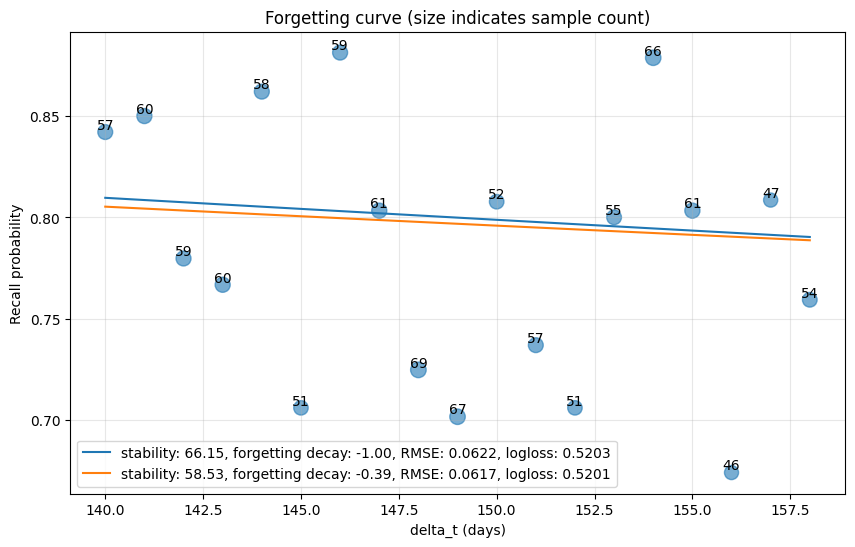

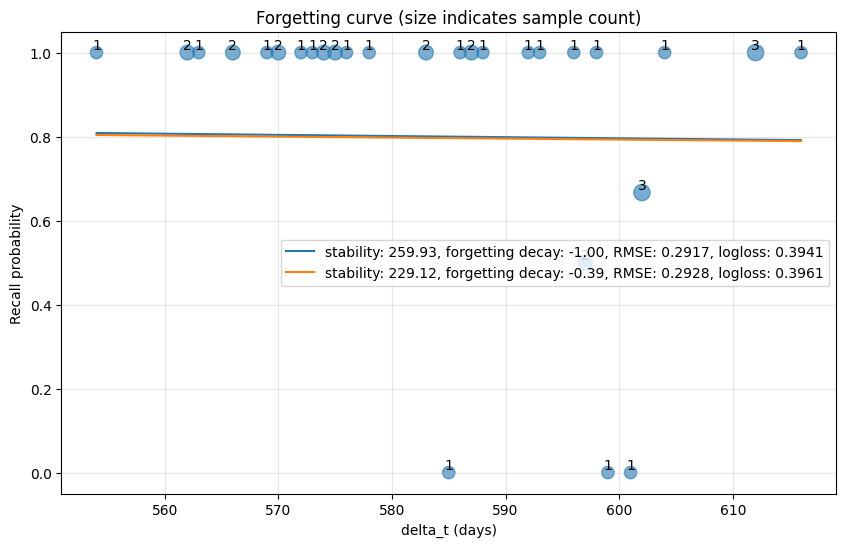

In [8]:
from fsrs_optimizer import power_forgetting_curve
from sklearn.metrics import root_mean_squared_error, log_loss

initial = Optimizer()
initial.dataset = dataset.copy()
initial.w = initial_parameters
loss_before, loss_after = initial.evaluate(save_to_file=False)
trained = Optimizer()
trained.dataset = dataset.copy()
trained.w = trained_parameters
loss_before, loss_after = trained.evaluate(save_to_file=False)
for r_history in ["3", "3,3", "3,3,3"]:
    t_history = df[df["r_history"] == r_history]["t_history"].value_counts().index[0]
    stabilities = []
    for df in [initial.dataset, trained.dataset]:
        tmp = df[(df["r_history"] == r_history) & (df["t_history"] == t_history)]
        points = tmp.groupby("delta_t")["y"].agg(["mean", "count"])
        stabilities.append(tmp["stability"].unique()[0])
    y_true = points["mean"]
    plt.figure(figsize=(10, 6))
    plt.scatter(
        points.index,
        y_true,
        s=np.sqrt(points["count"] / sum(points["count"])) * 500,
        alpha=0.6,
    )
    for x, y in zip(points.index, y_true):
        plt.text(x, y, points["count"][x], ha="center", va="bottom")

    for s, d in zip(stabilities, [initial_parameters[19], trained_parameters[19]]):
        y_pred = power_forgetting_curve(points.index, s, -d)
        rmse = root_mean_squared_error(y_true, y_pred, sample_weight=points["count"])
        logloss = log_loss(
            tmp["y"],
            power_forgetting_curve(tmp["delta_t"], s, -d),
        )
        plt.plot(
            points.index,
            y_pred,
            label=f"stability: {s:.2f}, forgetting decay: {-d:.2f}, RMSE: {rmse:.4f}, logloss: {logloss:.4f}",
        )
    plt.xlabel("delta_t (days)")
    plt.ylabel("Recall probability")
    plt.title("Forgetting curve (size indicates sample count)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [9]:
from fsrs_optimizer import FSRS
import torch

def calculate_retention(parameters, r_history, t_history, next_interval):
    """Calculate retention for given review history and parameters"""
    fsrs = FSRS(parameters)
    tensor = torch.tensor([t_history, r_history]).transpose(0, 1).unsqueeze(1)
    _, state = fsrs.forward(tensor)
    stability = state[0][0].item()
    retention = power_forgetting_curve(next_interval, stability, -parameters[19])
    print(next_interval, retention)

# Initial parameters
calculate_retention(initial_parameters, [3], [0], 30)
calculate_retention(initial_parameters, [3, 3], [0, 30], 145)

# Trained parameters  
calculate_retention(trained_parameters, [3], [0], 30)
calculate_retention(trained_parameters, [3, 3], [0, 30], 145)


# Initial parameters
calculate_retention(initial_parameters, [3], [0], 15)
calculate_retention(initial_parameters, [3, 3], [0, 15], 40)

# Trained parameters  
calculate_retention(trained_parameters, [3], [0], 15)
calculate_retention(trained_parameters, [3, 3], [0, 15], 40)

30 0.7974129587536983
145 0.8005118199232236
30 0.7928253413894116
145 0.7977785673813715
15 0.8872896513515888
40 0.9011828027678946
15 0.8754579535051222
40 0.8946070716320975


In [13]:
from fsrs_optimizer import next_interval

s = 30
for dr in [0.9, 0.8, 0.7, 0.5]:
    print(f"stability: {s}, desired retention: {dr}")
    ivl = next_interval(s, dr, decay=-initial_parameters[19])
    true_retention = power_forgetting_curve(ivl, s, -initial_parameters[19])
    print(f"initial: {ivl}, true retention: {true_retention:.2f}")
    ivl = next_interval(s, dr, decay=-trained_parameters[19])
    true_retention = power_forgetting_curve(ivl, s, -initial_parameters[19])
    print(f"trained: {ivl}, true retention: {true_retention:.2f}")
    print()

stability: 30, desired retention: 0.9
initial: 30, true retention: 0.90
trained: 30, true retention: 0.90

stability: 30, desired retention: 0.8
initial: 67, true retention: 0.80
trained: 75, true retention: 0.78

stability: 30, desired retention: 0.7
initial: 116, true retention: 0.70
trained: 144, true retention: 0.65

stability: 30, desired retention: 0.5
initial: 270, true retention: 0.50
trained: 473, true retention: 0.36

